# Traveling Salesperson Problem. 

TSP is a classic optimization problem in computer science and operations research. The problem is defined as follows:

Given a set of cities and the distances between each pair of cities, the objective is to find the shortest possible route that allows a salesperson to visit each city exactly once and return to the starting city.

In other words, the salesperson wants to find the most efficient way to travel through all the cities, minimizing the total distance traveled.

The TSP is classified as an NP-hard problem, which means that it is computationally difficult to find an optimal solution for large instances of the problem. As the number of cities increases, the number of possible routes grows exponentially, making it infeasible to brute-force all possibilities.

## Dependencies and Libraries

In [3]:
!pip install cplex
!pip install docplex

ERROR: Could not find a version that satisfies the requirement cplex (from versions: none)
ERROR: No matching distribution found for cplex


In [2]:
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
import math
import time
import utils
from enum import Enum

## Assignment

In [3]:
def create_assignment_problem_model(costs_matrix):
    num_vertices = len(costs_matrix)

    # Create a binary optimization model
    model = Model(name='TSP_AP')

    # Create binary variables for edges
    x = {(i, j): model.binary_var(name=f'x_{i}_{j}') for i in range(num_vertices) for j in range(num_vertices)}

    for i in range(num_vertices):
        # Ensure that every vertex has exactly one outgoing edge
        model.add_constraint(model.sum(x[i, j] for j in range(num_vertices) if j != i) == 1, ctname='out_{0}'.format(i))
        # Ensure that every vertex has exactly one incoming edge
        model.add_constraint(model.sum(x[j, i] for j in range(num_vertices) if j != i) == 1, ctname='in_{0}'.format(i))

    # Objective function
    model.minimize(
        model.sum(costs_matrix[i][j] * x[(i, j)] for i in range(num_vertices) for j in range(num_vertices) if j != i))

    return model, x

## Miller–Tucker–Zemlin (MTZ) formulation

In [4]:
def create_MTZ_model(costs_matrix):
    num_vertices = len(costs_matrix)

    model, x = create_assignment_problem_model(costs_matrix)

    # Create variables for ordering of vertices
    u = [model.continuous_var(name=f'u_{i}') for i in range(num_vertices)]
    for i in range(1, num_vertices):
        model.add_constraint(u[i] >= 0, ctname=f'lower_bound_{i}')
        model.add_constraint(u[i] <= num_vertices - 1, ctname=f'upper_bound_{i}')

    # Ensure that there are no subtours
    for i in range(1, num_vertices):
        for j in range(1, num_vertices):
            if i != j:
                model.add_constraint(u[i] - u[j] + (num_vertices - 1) * x[i, j] <= num_vertices - 2,
                                     ctname=f'MTZ_{i}_{j}')

    return model

## Cut Set Formulation

In [5]:
def create_cut_set_model(costs_matrix, connected):
    num_vertices = len(costs_matrix)
    model, x = create_assignment_problem_model(costs_matrix)

    if connected:
        # Cut set constrains
        vertices_list = [v for v in range(num_vertices)]
        for subset in utils.generate_subsets(vertices_list):
            arc_list = utils.get_external_subset_acrs(subset, vertices_list)
            model.add_constraint(model.sum(x[(arc['from'], arc['to'])] for arc in arc_list) >= 1)

    return model

## Subtour Elimination Formulation

In [6]:
def create_subtour_elimination_model(costs_matrix, connected):
    num_vertices = len(costs_matrix)
    model, x = create_assignment_problem_model(costs_matrix)

    if connected:
        # Cut set constrains
        vertices_list = [v for v in range(num_vertices)]
        for subset in utils.generate_subsets(vertices_list):
            arc_list = utils.get_internal_subset_acrs(subset, vertices_list)
            model.add_constraint(model.sum(x[(arc['from'], arc['to'])] for arc in arc_list) <= len(subset) - 1)

    return model

## Branch and Bound

This function implements the branch-and-bound algorithm to solve the Traveling Salesman Problem (TSP) using the cut set formulation.

### Parameters:

- `costs_matrix`: A 2D list or array representing the costs between vertices in the TSP graph.
- `bb_type`: if chosen Binary, then only 2 childs will be created at every branching iteration

### Returns:

- `best_solution`: A dictionary containing the binary decision variables representing the edges of the best-found solution.

### Functionality:

The `branch_and_bound` function performs the following steps:

1. Create the initial TSP model that can generate multiple subtours
2. Initialize a stack with one node only (the initial one).
3. Initialize `best_objective_value` as positive infinity.
4. Until the stack is empty process the next node:
   - if the solution is not better than the best stop branching on the current node
   - if the solution is better than the current best, then it checks if it is feasible (number of sub-tours = 1) and, if so, overwrites the current best solution
   -  if the solution is better than the current best, but it is not feasible then branch
   

In [7]:
class BranchAndBoundType(Enum):
    BINARY = 0,
    TOTAL = 1


def branch_and_bound(costs_matrix, bb_type):
    num_vertices = len(costs_matrix)

    best_solution = None
    best_objective_value = float('inf')

    initial_model, x = create_assignment_problem_model(costs_matrix)

    stack = [initial_model]

    nodes_added = 0

    while stack:
        current_model = stack.pop(0)

        solution = current_model.solve()
        if solution is None:
            continue  # Infeasible solution, backtrack

        objective_value = solution.get_objective_value()

        if objective_value >= best_objective_value:
            continue  # Solution is worse than the best found so far, backtrack

        if utils.count_subtours(solution, num_vertices) == 1:
            # Found a feasible solution with lower objective value
            best_solution = solution
            best_objective_value = objective_value
            continue

        count_added_models = 0
        for i, j in itertools.product(range(num_vertices), repeat=2):
            current_var_value = solution.get_var_value(current_model.get_var_by_name(f'x_{i}_{j}'))
            if i != j and current_var_value == 1:
                new_model = current_model.clone()
                new_model.add_constraint(new_model.get_var_by_name(f'x_{i}_{j}') == 0)
                stack.append(new_model)

                nodes_added += 1
                count_added_models += 1
                if bb_type == BranchAndBoundType.BINARY and count_added_models == 2:
                    break

    if best_solution is None:
        raise Exception("Infeasible")

    print("\tNodes added", nodes_added)

    return best_solution

## Solvers

We then write some functions that allow us, given a cost matrix, to solve the TSP using the methods we have developed.

In particular we have:
- resolution with the Cut Set formulation
- resolution with the Subtour Elimination formulation
- Branch and Bound resolution
- resolution with Miller–Tucker–Zemlin formulation
- resolution using the brute force algorithm

In [8]:
def solve_with_cut_set(costs_matrix, connected=True, visualize=True, print_time=True):
    print("Cut Set")
    num_vertices = len(costs_matrix)

    model = create_cut_set_model(costs_matrix, connected)

    start_time = time.time()
    solution = model.solve()
    if print_time:
        print("\tTime:", time.time() - start_time)

    if visualize:
        utils.print_tours(solution, num_vertices, method_name="Cut Set")

    print("\tTotal Cost:   ", solution.get_objective_value())


def solve_with_subtour_elimination(costs_matrix, connected=True, visualize=True, print_time=True):
    print("Subtour Elimination")
    num_vertices = len(costs_matrix)

    model = create_subtour_elimination_model(costs_matrix, connected)

    start_time = time.time()
    solution = model.solve()
    if print_time:
        print("\tTime:", time.time() - start_time)

    if visualize:
        utils.print_tours(solution, num_vertices, method_name="Subtour Elimination")

    print("\tTotal Cost:   ", solution.get_objective_value())


def solve_with_branch_and_bound(costs_matrix, bb_type, visualize=True, print_time=True):
    print("Branch and Bound")
    num_vertices = len(costs_matrix)

    start_time = time.time()
    solution = branch_and_bound(costs_matrix, bb_type)
    if print_time:
        print("\tTime:", time.time() - start_time)

    if visualize:
        utils.print_tours(solution, num_vertices, method_name="Branch and Bound")

    print("\tTotal Cost:   ", solution.get_objective_value())


def solve_with_MTZ(costs_matrix, visualize=True, print_time=True):
    print("Miller–Tucker–Zemlin")
    num_vertices = len(costs_matrix)

    model = create_MTZ_model(costs_matrix)

    start_time = time.time()
    solution = model.solve()
    if print_time:
        print("\tTime:", time.time() - start_time)

    if visualize:
        utils.print_tours(solution, num_vertices, method_name="Miller–Tucker–Zemlin")

    print("\tTotal Cost:   ", solution.get_objective_value())


def solve_with_brute_force(cost_matrix, print_time=True):
    print("Brute Force")

    start_time = time.time()

    n_vertices = len(cost_matrix)
    best_path = None
    best_cost = float('inf')

    # Generate all possible permutations of vertices
    permutations = itertools.permutations(range(n_vertices))

    # Iterate through each permutation
    for permutation in permutations:
        current_cost = 0

        # Calculate the cost of the current permutation
        for i in range(n_vertices - 1):
            current_cost += cost_matrix[permutation[i]][permutation[i + 1]]

        current_cost += cost_matrix[permutation[n_vertices - 1]][permutation[0]]

        # Check if the current permutation gives a better cost
        if current_cost < best_cost:
            best_path = permutation
            best_cost = current_cost

    if print_time:
        print("\tTime:", time.time() - start_time)

    print("\tTotal Cost:   ", best_cost)

    return best_path, best_cost

## Tests

### Set up the number of verficies and the cost matrix

In [9]:
num_vertices = 15
costs_matrix = utils.generate_random_cost_matrix(num_vertices)

### Using Cut Set Formulation
`connected = False` removes the connection constrains.

It is the fastest way, but there is a chance to get a disconnected solution.

The solution produced without considering the connection constraints gives us a lower bound to the traveling salesman problem

`connected = True`

Produces the optimal solution to the traveling salesman problem, but requires an exponential number of constraints.

> You need to be careful about choosing the number of vertices as the program could crash

Cut Set
	Time: 0.0044651031494140625


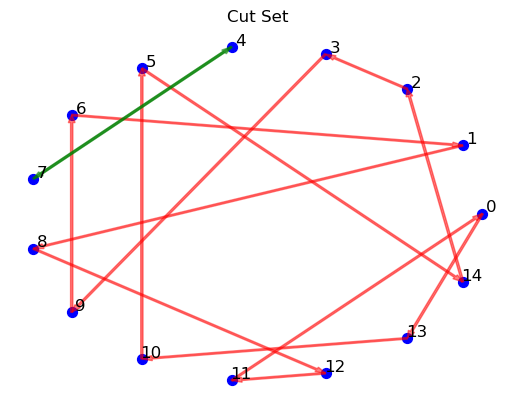

	Number of tours: 2
	TSP tours:
	[0, 13, 10, 5, 14, 2, 3, 9, 6, 1, 8, 12, 11, 0]
	[4, 7, 4]
	Total Cost:    98.0


In [10]:
solve_with_cut_set(costs_matrix, connected=False, visualize=True, print_time=True)

### Using Subtour Elimination Formulation *without connection constrains*
`connected = False` removes the connection constrains.

It is the fastest way, but there is a chance to get a disconnected solution.

The solution produced without considering the connection constraints gives us a lower bound to the traveling salesman problem

`connected = True`

Produces the optimal solution to the traveling salesman problem, but requires an exponential number of constraints.

> You need to be careful about choosing the number of vertices as the program could crash

Subtour Elimination
	Time: 0.005178928375244141


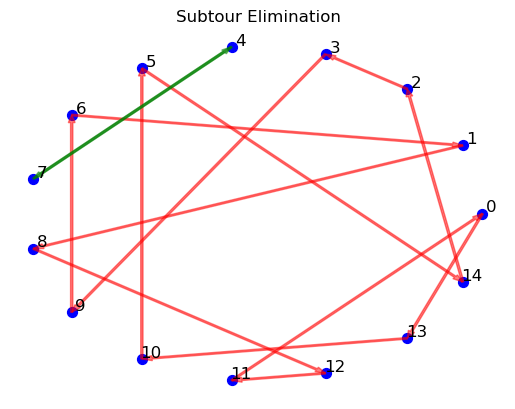

	Number of tours: 2
	TSP tours:
	[0, 13, 10, 5, 14, 2, 3, 9, 6, 1, 8, 12, 11, 0]
	[4, 7, 4]
	Total Cost:    98.0


In [11]:
solve_with_subtour_elimination(costs_matrix, connected=False, visualize=True, print_time=True)

### Using Branch and Bound

Should produce the same result as the cut set formulation with connection constrains.

In [12]:
solve_with_branch_and_bound(costs_matrix, bb_type=BranchAndBoundType.BINARY, visualize=True, print_time=True)

Branch and Bound


KeyboardInterrupt: 

## Using Miller–Tucker–Zemlin

Miller–Tucker–Zemlin
	Time: 0.03092193603515625


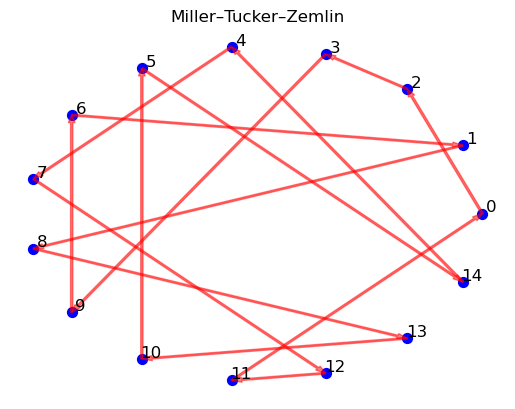

	Number of tours: 1
	TSP tours:
	[0, 2, 3, 9, 6, 1, 8, 13, 10, 5, 14, 4, 7, 12, 11, 0]
	Total Cost:    110.0


In [14]:
solve_with_MTZ(costs_matrix, visualize=True, print_time=True)